In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM


## Data

In [3]:
# Loading the data 

x = np.linspace(0,50, 501)
y = np.sin(x)


df = pd.DataFrame(data=y, index=x, columns=['Sinus'])

print(df.shape)

# Splitting the data

df_train = df.iloc[: int(len(df) - len(df) * 0.1)]
df_test  = df.iloc[int(len(df) - len(df) * 0.1): ]

print(df_train.shape, df_test.shape)

# Scaling the data

scaler = MinMaxScaler()
train = scaler.fit_transform(df_train)
test  = scaler.transform(df_test)

(501, 1)
(450, 1) (51, 1)


In [4]:
# Generate train 

length     = 50 # Temporel step
batch_size = 1
output     = 1

# targets = label if timeseries target = data 
generator = TimeseriesGenerator(data=train, targets=train, length=length, batch_size=batch_size)

len(generator), len(train) - length, generator[0][0], generator[0][1], len(generator)

(400, 400, array([[[4.99999116e-01],
         [5.49916225e-01],
         [5.99334579e-01],
         [6.47760405e-01],
         [6.94709850e-01],
         [7.39713809e-01],
         [7.82322618e-01],
         [8.22110545e-01],
         [8.58680040e-01],
         [8.91665714e-01],
         [9.20737985e-01],
         [9.45606372e-01],
         [9.66022399e-01],
         [9.81782075e-01],
         [9.92727935e-01],
         [9.98750612e-01],
         [9.99789928e-01],
         [9.95835500e-01],
         [9.86926839e-01],
         [9.73152957e-01],
         [9.54651478e-01],
         [9.31607263e-01],
         [9.04250562e-01],
         [8.72854714e-01],
         [8.37733417e-01],
         [7.99237589e-01],
         [7.57751870e-01],
         [7.13690771e-01],
         [6.67494535e-01],
         [6.19624741e-01],
         [5.70559686e-01],
         [5.20789614e-01],
         [4.70811810e-01],
         [4.21125636e-01],
         [3.72227539e-01],
         [3.24606094e-01],
         [2.787371

In [5]:
# Generate val_cross

validation_generator = TimeseriesGenerator(data=test, targets=test, length=length, batch_size=batch_size)

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()

model.add(SimpleRNN(units=length, input_shape=(length, output)))
model.add(Dense(output))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/20
400/400 [==============================] - 4s 8ms/step - loss: 0.0031 - val_loss: 2.9111e-05
Epoch 2/20
400/400 [==============================] - 3s 7ms/step - loss: 5.4953e-04 - val_loss: 1.9929e-05
Epoch 3/20
400/400 [==============================] - 3s 7ms/step - loss: 2.4640e-05 - val_loss: 1.1017e-06
Epoch 4/20
400/400 [==============================] - 3s 7ms/step - loss: 8.5162e-05 - val_loss: 7.1372e-05
Epoch 5/20
400/400 [==============================] - 3s 7ms/step - loss: 2.9866e-04 - val_loss: 9.0648e-07
Epoch 6/20
400/400 [==============================] - 3s 7ms/step - loss: 2.1977e-05 - val_loss: 1.4054e-07
Epoch 7/20
400/400 [==============================] - 3s 7ms/step - loss: 2.6264e-05 - val_loss: 6.3311e-05
Epoch 8/20
400/400 [==============================] - 3s 7ms/step - loss: 1.8046e-04 - val_loss: 3.5174e-05


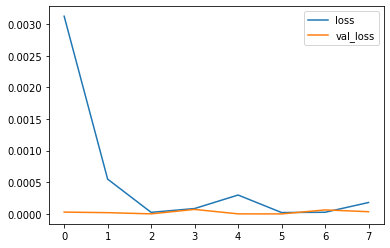

In [8]:
losses = pd.DataFrame(model.history.history)

losses.plot()

In [9]:
[4,54,54,54,54,68435,146,513,516,81][-2:]

[516, 81]

## Generate the time series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


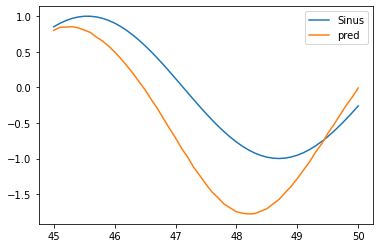

In [10]:
## Generate the time series

test_predictions = []
first_eval_batch = train[-length:]
current_batch    = first_eval_batch.reshape(output, length, output) # 1, 50, 1

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0] # shape (1, 1)
  test_predictions.append(current_pred)
  # Shift the current_batch by1
  # [current_pred]: To have 3 dims
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
  
# Inverse transform
df_test['pred'] = scaler.inverse_transform(test_predictions)

# Plot the result 

df_test.plot()